<a href="https://colab.research.google.com/github/deyaliao/surestart2021/blob/main/autoencoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# fully-connected neural layer as encoder and decoder
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)


In [10]:
# separate encoder and decoder model
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


goal: to train our encoder to reconstruct mnist digits

In [11]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()


In [12]:
# normalize data through 0 to 1, flatten dimensions
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [13]:
# train our encoder 
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 3s 3ms/step - loss: 0.3853 - val_loss: 0.1926
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1827 - val_loss: 0.1551
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1506 - val_loss: 0.1336
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1316 - val_loss: 0.1213
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1198 - val_loss: 0.1124
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1119 - val_loss: 0.1062
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1063 - val_loss: 0.1017
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1022 - val_loss: 0.0986
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0995 - val_loss: 0.0965
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0973 - val_loss: 0.0952

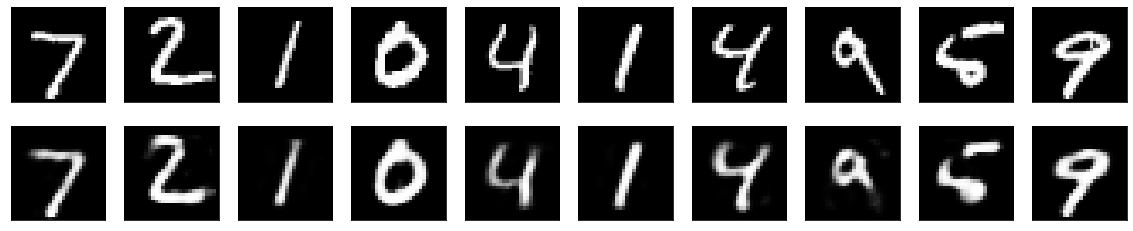

In [15]:
# visualize reconstructed inputs through matplotlib

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


adding a sparsity constraint on encoded representations

In [7]:
#Adding a sparsity constraint on the encoded representations
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)


In [9]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# train our encoder 
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3902 - val_loss: 0.2022
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1906 - val_loss: 0.1631
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1596 - val_loss: 0.1452
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1434 - val_loss: 0.1342
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1332 - val_loss: 0.1250
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1244 - val_loss: 0.1186
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1187 - val_loss: 0.1140
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1142 - val_loss: 0.1107
Epoch 9/50
235/235 [==============================] - 2s 11ms/step - loss: 0.1112 - val_loss: 0.1086
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1094 - val_lo

Application to image denoising: irl example

In [16]:
#Application to image denoising
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


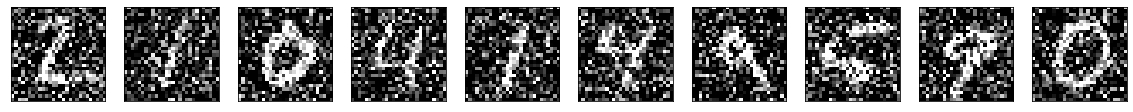

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [18]:
from keras.callbacks import TensorBoard

# new model: slightly improved (more filters per layer)
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [19]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])


Epoch 1/100
469/469 [==============================] - 9s 7ms/step - loss: 0.2319 - val_loss: 0.1156
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1139 - val_loss: 0.1080
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1072 - val_loss: 0.1045
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1040 - val_loss: 0.1018
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1019 - val_loss: 0.1004
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1009 - val_loss: 0.0992
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0996 - val_loss: 0.0989
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0991 - val_loss: 0.0980
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0983 - val_loss: 0.0975
Epoch 10/100
469/469 [==============================] - 3s 7ms/step - loss: 0.0979 - val_lo

In [ ]:
# reference for sequence to sequence encoder
timesteps = ...  # Length of your sequences
input_dim = ... 
latent_dim = ...

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = layers.LSTM(latent_dim)(inputs)

decoded = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)


varational encoder (VAE)

In [20]:
# Variational autoencoder (VAE)
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [ ]:
# sample similar points to latent space
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


In [ ]:
# map these sampled latent points back to resconstructed images
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
